[Link to Page](https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
# transform : to tensor, normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

# load data
trainset = torchvision.datasets.FashionMNIST('./data',
                                             download=True,
                                             train=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
                                            download=True,
                                            train=False,
                                            transform=transform)

# data -> dataloader
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

In [3]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input : 4 * 1 * 28 * 28
        # output : {(28-5) / 1} + 1 = 24 --> 4 * 6 * 24 * 24
        self.conv1 = nn.Conv2d(1, 6, 5)
        # output : {(24 - 2) / 2} + 1 = 14 --> 6 * 12 * 12
        self.pool = nn.MaxPool2d(2, 2)
        # output : {(12 - 5) / 1} + 1 = 12 --> 16 * 8 * 8
        self.conv2 = nn.Conv2d(6, 16, 5)
        # pool --> 16 * 4 * 4
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

# Tensorboard 설정

In [5]:
from torch.utils.tensorboard import SummaryWriter

# default dir : runs/
writer = SummaryWriter('runs/fashion_mnist_experiment1')

# Tensorboard 기록

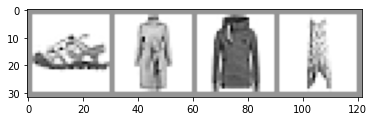

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)

# !tensorboard --logdir=runs

# Tensorboard 모델 보기

In [8]:
writer.add_graph(net, images)
writer.close()

# Tensorboard - Project

In [9]:
# Why doesnt work ? T_T

def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    # random index within len(data)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


images, labels = select_n_random(trainset.data, trainset.targets)


class_labels = [classes[lab] for lab in labels]


features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

# Tensorboard - Trace Model Training

In [10]:
def images_to_probs(net, images):
    output = net(images)
    _, pred_tensor = torch.max(output, axis=1)
    preds = np.squeeze(pred_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{}, {:.1f}%\n(label: {})".format(classes[preds[idx]], probs[idx] * 100.0, classes[labels[idx]]),
                     color=('green' if preds[idx] == labels[idx].item() else "red"))
    return fig

In [11]:
running_loss = 0.
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:

            writer.add_scalar('training loss', running_loss /
                              1000, epoch*len(trainloader) + i)
            writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels),
                              global_step=epoch * len(trainloader) + 1)
            running_loss = 0.


print("Finished Training")

Finished Training


# Tensorboard - Test

In [12]:
class_probs = []
class_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

In [13]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index], tensorboard_preds,
                        tensorboard_probs, global_step=global_step)
    writer.close()


for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)